## 辅助变量

In [3]:
import os
pdf_path = r"Paper" # 存放pdf的文件夹
image_path = r"Images" # 存放图片的文件夹
api_key = os.environ.get("QWEN_API_KEY")

## 大语言模型

In [4]:
from openai import OpenAI
client = OpenAI(
    api_key=api_key,
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

## 辅助函数

In [5]:
import base64
'''
API调用准备：许多AI模型的API（如OpenAI GPT-4V、Qwen等）需要图像以Base64编码格式传输
数据传输：Base64编码可以将二进制图像数据转换为文本格式，便于在JSON等文本协议中传输
存储和处理：编码后的图像可以更容易地存储在数据库中或与文本数据一起处理

打开图像文件并将其编码为Base64字符串，rb表示以二进制读模式打开文件
'''
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [6]:
'''
可视化调试：将处理过的图像显示出来，便于查看和验证
结果展示：在RAG系统中展示检索到的图像内容
数据预览：在处理图像数据时预览图像内容

根据Base64字符串生成HTML标签并显示图像
'''
from IPython.display import display, HTML
def plt_img_base64(img_64):
    img_html = f'<img src="data:image/jpeg;base64,{img_64}" style="max-width: 500px;"/>'
    display(HTML(img_html))

## pdf分割

In [5]:
'''
分割工具：PP-StructureV3
输入：PDF文件
输出：排版好的Markdown文本，包含文内容、图片图表引用、公式
图片图表路径：Output/imgs
'''

from pathlib import Path
from paddleocr import PPStructureV3
import time

input_file = "Paper/论文标注-5.pdf"
output_path = Path("Output")

start_time = time.time()

pipeline = PPStructureV3(
    text_recognition_model_name = "en_PP-OCRv4_mobile_rec", # 选择英文模型
    formula_recognition_model_name= "PP-FormulaNet_plus-S", # 选择公式识别模型
)

load_time = time.time() - start_time
print("模型加载时间: {:.2f} 秒".format(load_time))

output = pipeline.predict(input=input_file)

predict_time = time.time() - start_time - load_time
print("预测时间: {:.2f} 秒".format(predict_time))

markdown_list = []
markdown_images = []

for res in output:
    md_info = res.markdown
    markdown_list.append(md_info)
    markdown_images.append(md_info.get("markdown_images", {}))

markdown_texts = pipeline.concatenate_markdown_pages(markdown_list)

mkd_file_path = output_path / f"{Path(input_file).stem}.md"
mkd_file_path.parent.mkdir(parents=True, exist_ok=True)

with open(mkd_file_path, "w", encoding="utf-8") as f:
    f.write(markdown_texts)

for item in markdown_images:
    if item:
        for path, image in item.items():
            # 跳过文件名包含"formula"的图片
            if "formula" in path.lower():
                continue
            
            file_path = output_path / path
            file_path.parent.mkdir(parents=True, exist_ok=True)
            image.save(file_path)
            print(f"保存图片: {path}")
            

KeyboardInterrupt: 

## 图像总结


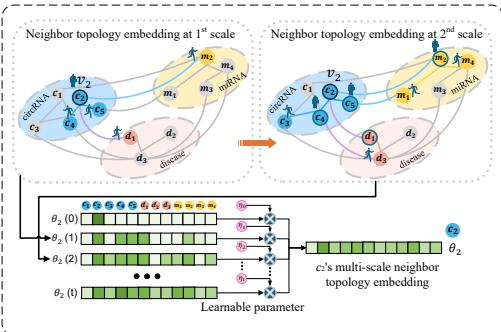

In [23]:
local_path = "C:\\Users\\71949\\Desktop\\Python Code\\Output\\imgs\\img_in_image_box_98_106_599_438.jpg"
base64_image = encode_image(local_path)
plt_img_base64(base64_image)

response = client.chat.completions.create(
    model="qwen-vl-max-latest",
    messages=[
    	{
    	    "role": "system",
            "content": [{"type":"text","text": "You are a helpful assistant."}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    # 需要注意，传入Base64，图像格式（即image/{format}）需要与支持的图片列表中的Content Type保持一致。"f"是字符串格式化的方法。
                    # PNG图像：  f"data:image/png;base64,{base64_image}"
                    # JPEG图像： f"data:image/jpeg;base64,{base64_image}"
                    # WEBP图像： f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}, 
                },
                {"type": "text", "text": "用英文回答图中描绘的是什么?"},
            ],
        }
    ],
)

img_description = response.choices[0].message.content

## 切块

In [6]:
import re # 用于正则表达式处理，匹配文字

def has_formula(text):
    """检测文本是否包含LaTeX公式"""
    formula_patterns = [
        r'\$\$.*?\$\$',  # 块级公式
        r'\$.*?\$',      # 行内公式
    ]
    for pattern in formula_patterns:
        if re.search(pattern, text, re.DOTALL): # re.DOTALL 使 . 能匹配换行符，匹配多行公式
            return True
    return False

In [7]:
def split_with_formula_protection(text, max_chunk_size, chunk_overlap=0):
    """
    分割文本时保护公式完整性
    """
    # 找到所有公式的位置
    formula_pattern = r'(\$\$.*?\$\$|\$.*?\$)'
    parts = re.split(formula_pattern, text, flags=re.DOTALL) # 将公式都单独摘出来
    
    chunks = []
    current_chunk = "" # 当前块内容
    
    for part in parts:
        if re.match(formula_pattern, part, re.DOTALL): # 匹配得知这是一个公式
            if len(current_chunk + part) > max_chunk_size and current_chunk: # 当前块太大，先输出当前块
                # 输出当前块
                chunks.append(current_chunk.strip()) # strip()可以去除首尾多余的空白，比如说"这是一个公式 $x=y$"切割后得到"这是一个公式 "，多出一个空格
                # 简单overlap: 取前一块末尾部分
                overlap_text = chunks[-1][-chunk_overlap:] if chunk_overlap > 0 and chunks else ""
                current_chunk = overlap_text + part # 新块以overlap+公式开头
            else:
                current_chunk += part # 长度没有超过chunk_size，公式直接添加到当前块
        else:
            # 普通文本，可以进一步分割
            if len(current_chunk + part) > max_chunk_size:
                # 需要分割
                if current_chunk: # 当前块不为空，防止是单独part过大
                    # 输出当前块
                    chunks.append(current_chunk.strip())
                    # 简单overlap: 取前一块末尾部分
                    overlap_text = chunks[-1][-chunk_overlap:] if chunk_overlap > 0 else ""
                    current_chunk = overlap_text # 重置当前块
                
                # 分割普通文本
                words = part.split() # 按空格分词
                for word in words: # 逐词添加，防止单词被切断
                    if len(current_chunk + word + " ") > max_chunk_size and current_chunk:
                        chunks.append(current_chunk.strip()) # 输出当前块
                        # 简单overlap: 取前一块末尾部分
                        overlap_text = chunks[-1][-chunk_overlap:] if chunk_overlap > 0 else ""
                        current_chunk = overlap_text + word + " " # 新块以overlap+当前词开头
                    else: # 长度没有超过chunk_size，词直接添加到当前块
                        current_chunk += word + " " # 注意加空格
            else: # 长度没有超过chunk_size，普通文本直接添加到当前块
                current_chunk += part # 注意这里不加空格，因为part本身可能包含空格
    
    if current_chunk.strip(): # 最后一个块不为空
        chunks.append(current_chunk.strip()) # strip()去除首尾空白
    
    return chunks

In [8]:
'''
1. LangChain MarkdownHeaderTextSplitter + RecursiveCharacterTextSplitter
   - 优点：按标题层级分割，保持语义完整性
   - 适合：学术论文的章节结构

2. 自定义公式感知分割器
   - 保护LaTeX公式完整性
   - 识别并保持图片引用与说明文字的关联

元数据设计：
每个chunk应包含：
- 章节信息：所属章节标题  
- 公式编号：如果包含公式
- 图片路径：如果引用图片
'''

from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter

def markdown_semantic_splitter(markdown_text, chunk_size=800, chunk_overlap=100):
    """
    智能markdown分割器，保护公式和图片引用
    """
    
    # 1. 按标题层级分割
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"), 
        ("###", "Header 3"),
        ("####", "Header 4"),
    ]
    
    markdown_splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=headers_to_split_on,
        strip_headers=False
    )
    
    # 2. 初步按标题分割
    md_header_splits = markdown_splitter.split_text(markdown_text)
    
    # 3. 进一步细分大块内容，但保护公式
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=[ # 优先使用更大粒度的分隔符，超过chunk_size时再使用更小粒度的分隔符，直到句子分割也超过chunk_size，则强制分割，并且出发overlap
            "\n\n",  # 段落分隔
            ". ",    # 句子分隔  
        ]
    )
    
    # 保留metadata，如章节信息，检索的时候可以考虑章节关联
    
    final_chunks = []
    for doc in md_header_splits:
        # 检查是否包含公式，如果包含则特殊处理
        if has_formula(doc.page_content):
            # 传递overlap参数给公式保护分割器
            formula_chunks = split_with_formula_protection(doc.page_content, chunk_size, chunk_overlap)
            for chunk_text in formula_chunks:
                final_chunks.append({
                    'content': chunk_text,
                    'metadata': {
                        **doc.metadata,
                        'has_formula': True,
                    }
                })
        else:
            # 普通文本按常规方式分割
            splits = text_splitter.split_text(doc.page_content)
            for split_text in splits:
                final_chunks.append({
                    'content': split_text,
                    'metadata': {
                        **doc.metadata,
                        'has_formula': False,
                    }
                })
    
    return final_chunks


In [9]:
from langchain.document_loaders import DirectoryLoader, TextLoader

def load_document(file_path):
    loader = DirectoryLoader(
        file_path,
        glob="**/*.md",
        loader_cls=TextLoader,
        loader_kwargs={"encoding": "utf-8"}
    )
    
    documents = loader.load()
    
    return documents

In [10]:
documents = load_document("Output")
print(f"总共加载了 {len(documents)} 个文档")
chunks = markdown_semantic_splitter(documents[0].page_content)
print(f"总共分割成 {len(chunks)} 个chunk")

总共加载了 1 个文档
总共分割成 10 个chunk


## 向量化模型

In [7]:
from langchain.embeddings import HuggingFaceEmbeddings
import os
import time
os.environ["TRANSFORMERS_OFFLINE"] = "1" # 离线模式，避免下载模型
# 全局模型缓存：只在首次运行时加载模型
if 'embedding' not in globals():
    print("首次加载嵌入模型...")
    model_start = time.time()
    
    embedding = HuggingFaceEmbeddings( # 需要开Vpn
        model_name='Qwen/Qwen3-Embedding-0.6B',
        cache_folder='Models',
        model_kwargs={'device': 'cuda:0'},
        encode_kwargs={'normalize_embeddings': True}
    )
    print(f"✅ 嵌入模型加载完成 (设备: cuda:0)，耗时: {time.time() - model_start:.2f}秒")
else:
    print("使用已缓存的嵌入模型 ✓")

首次加载嵌入模型...


C:\Users\71949\AppData\Local\Temp\ipykernel_113460\1703917666.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings( # 需要开Vpn


✅ 嵌入模型加载完成 (设备: cuda:0)，耗时: 11.18秒


In [8]:
'''
向量存储
'''
from langchain.document_loaders import markdown
from langchain_chroma import Chroma


persist_dir = "./chroma_db"
collection_name = "pdf_img_rag"

vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding,
    persist_directory=persist_dir
)
retriever = vector_store.as_retriever(search_kwargs={"k": 1})

## 数据插入

In [37]:
# 插入文本
vector_store.add_texts(
    texts=[chunk['content'] for chunk in chunks],
    metadatas=[chunk['metadata'] for chunk in chunks],
    ids=[f"doc_{i}" for i in range(len(chunks))]
)
retriever_doc = vector_store.get(ids=["doc_0"], include=['embeddings', 'metadatas', 'documents'])
print(retriever_doc)

包含embeddings的结果:
文档ID: ['doc_0']
元数据: [{'has_formula': True}]
文档内容长度: 344
Embeddings形状: 1024


In [41]:
print(img_description)
# 插入图片
vector_store.add_texts(
    texts=[f"图片描述: {img_description}"],
    metadatas=[{"source": local_path}],
    ids=[f"img_{i}" for i in range(1)]
)
# 查看该图片的存储情况
retrieved_docs = vector_store.get(ids=["img_0"], include=['metadatas', 'documents'])
print(retrieved_docs)

The figure illustrates a multi-scale neighbor topology embedding approach in a biological network context, specifically focusing on gene regulatory networks involving circRNA, miRNA, and disease interactions.

Here's a breakdown of what the figure depicts:

1. **Top Part (Two Panels)**:
   - **Left Panel**: Shows the neighbor topology embedding at the 1st scale. It includes nodes representing different biological entities such as circRNA (c₁), miRNA (m₁, m₂, m₃), and disease (d₁, d₂). The connections between these nodes represent interactions or relationships.
   - **Right Panel**: Depicts the neighbor topology embedding at the 2nd scale. This scale appears to refine or expand upon the first scale, possibly incorporating more detailed or higher-order relationships among the same entities.

2. **Bottom Part**:
   - **Embedding Process**: A series of vectors labeled θ₂(0), θ₂(1), ..., θ₂(t) represent embeddings at different time steps or scales. These are processed through learnable para

## 检索

In [9]:
def process_retrieved_docs(question):
    relevant_docs = retriever.get_relevant_documents(question)
    return relevant_docs

## prompt模版

In [10]:
from langchain.prompts import PromptTemplate

prompt_img_with_history = PromptTemplate(
    input_variables=["image", "context", "question", "chat_history", "conversation_summary"],
    template="""
你是一个专业的学术文献分析助手。基于提供的信息回答用户问题。

【对话背景】
{conversation_summary}

【最近对话历史】
{chat_history}

【当前检索信息】
图片/表格描述: {image}
文本信息: {context}

【用户当前问题】
{question}

【回答要求】
1. 如果用户问题与之前的对话相关，请结合历史上下文回答
2. 优先使用当前检索到的信息
3. 如果检索信息不足，可以基于对话历史提供补充
4. 保持回答的连贯性和准确性
5. 使用中文回答，输出为markdown格式

请基于以上信息提供详细、准确的回答：
""",
)

# 简化版prompt，用于没有历史的首次对话
prompt_img_init = PromptTemplate(
    input_variables=["image", "context", "question"],
    template="""
你是一个专业的学术文献分析助手。

【检索信息】
图片/表格描述: {image}
文本信息: {context}

【用户问题】
{question}

请基于提供的信息，用中文提供详细、准确的回答，输出为markdown格式：
""",
)

## 对话系统

In [12]:
doc = process_retrieved_docs("what is topology?")

if "source" in doc[0].metadata:
    print(f"检索到图片，路径: {doc[0].metadata['source']}")
    img_description = doc[0].page_content
    context = "No text retrieved."
else:
    print("检索到文本")
    img_description = "No image retrieved."
    context = doc[0].page_content

response = client.chat.completions.create(
    model="qwen3-next-80b-a3b-instruct",
    messages=[
    	{
    	    "role": "system",
            "content": [{"type":"text","text": "You are a helpful assistant."}]},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_img_init.format(
                    image=img_description,
                    context=context,
                    question="what is topology?"
                )},
            ],
        }
    ],
)

print(response.choices[0].message.content)

检索到文本
```markdown
在提供的文献上下文中，“拓扑”（topology）指的是**网络或图结构中节点之间的连接关系与组织方式**，即节点如何通过边（edges）相互关联所形成的结构模式。

具体而言，在图3的描述中提到“自适应构建多尺度邻居拓扑嵌入”（adaptively constructing multi-scale neighbor topology embeddings），这里的“拓扑”特指：

1. **节点间的邻接关系**：以节点 $ c_2 $ 为例，其“邻居拓扑”包括直接相连的一阶邻居（1-hop neighbors）、可通过两步到达的二阶邻居（2-hop neighbors），直至 d 阶邻居（d-scale neighbors，其中 $ d > 1 $）。这些层级关系构成了一个从局部到全局的多尺度邻域结构。

2. **结构化连接模式**：拓扑不仅表示“谁连着谁”，还隐含了连接的层次性、密度、路径长度等结构性特征。例如，随机游走（RwR, Random Walk with Restart）被用于探索这些多尺度邻居，说明拓扑是动态可扩展的，而非静态的邻接矩阵。

3. **嵌入建模的基础**：在图神经网络或表示学习中，拓扑结构是生成节点嵌入（embedding）的核心依据。通过捕获不同尺度的邻居拓扑，模型可以更全面地理解节点在全局网络中的角色和语义位置。

因此，在本研究背景下，“拓扑”不是几何或空间意义上的形状，而是**图数据中节点间依赖与传播关系的抽象结构模型**，是实现自适应多尺度表征学习的关键输入。
```
